In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout

"""
    Helper function that create a window of length 'window_size'
    X[i] will be the values from index i to i+window_size-1,
    y[i] will be the value at index i+window_size.
"""
def create_sliding_windows(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


In [13]:
# Data preprocessing 
df = pd.read_csv('Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

date_cols = [col for col in df.columns if re.match(r'\d{4}-\d{2}-\d{2}', col)]

# handling missing value 
df.dropna(subset=date_cols, inplace=True)
df.reset_index(drop=True, inplace=True)


# Apply scaler 
all_values = df[date_cols].values.flatten().reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(all_values)

# Create sliding windows across all regions
window_size = 12 
X_list, y_list = [], []

for i in range(len(df)):
    region_series = df.loc[i, date_cols].values.reshape(-1, 1)
    region_series_scaled = scaler.transform(region_series)
    
    X_region, y_region = create_sliding_windows(region_series_scaled, window_size=window_size)
    X_list.append(X_region)
    y_list.append(y_region)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Reshape X to [samples, timesteps, features], y to [samples, 1]
y = y.reshape(-1, 1)

# 80% and 20% train and split 

num_samples = X.shape[0]
train_size = int(num_samples * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]




Training model with units=32, dropout=0.0, lr=0.001 ...

Training model with units=32, dropout=0.0, lr=0.0001 ...

Training model with units=32, dropout=0.2, lr=0.001 ...

Training model with units=32, dropout=0.2, lr=0.0001 ...

Training model with units=64, dropout=0.0, lr=0.001 ...

Training model with units=64, dropout=0.0, lr=0.0001 ...

Training model with units=64, dropout=0.2, lr=0.001 ...

Training model with units=64, dropout=0.2, lr=0.0001 ...

Hyperparameter Tuning Results (sorted by final_val_loss):
   units  dropout  learning_rate  final_val_loss
0     32      0.0         0.0010    3.103176e-07
4     64      0.0         0.0010    3.419919e-07
5     64      0.0         0.0001    2.127746e-06
1     32      0.0         0.0001    3.454111e-06
6     64      0.2         0.0010    3.821227e-06
3     32      0.2         0.0001    4.620731e-06
7     64      0.2         0.0001    4.658057e-06
2     32      0.2         0.0010    5.854383e-06


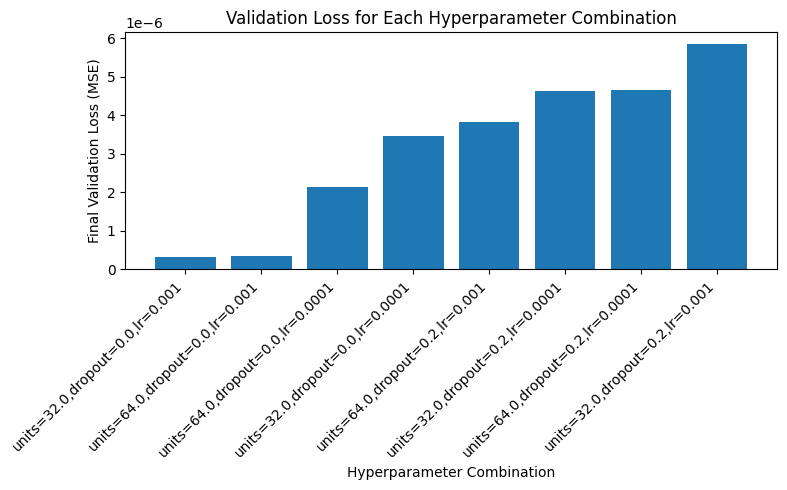


Best combination found:
units             3.200000e+01
dropout           0.000000e+00
learning_rate     1.000000e-03
final_val_loss    3.103176e-07
Name: 0, dtype: float64


In [14]:
# This is a helper function for us to do grid search. It build a model using different hyperparameters

def build_lstm_model(input_shape, num_units=64, dropout_rate=0.0, learning_rate=1e-3):
    model = Sequential()
    model.add(LSTM(num_units, input_shape=input_shape, return_sequences=False))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # single output for regression
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Grid search 
num_units_list = [32, 64]
dropout_list = [0.0, 0.2]
learning_rates = [1e-3, 1e-4]

results = []

for units in num_units_list:
    for dropout in dropout_list:
        for lr in learning_rates:
            print(f"\nTraining model with units={units}, dropout={dropout}, lr={lr} ...")
            
     
            model = build_lstm_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                num_units=units,
                dropout_rate=dropout,
                learning_rate=lr
            )
            

            history = model.fit(
                X_train, y_train,
                epochs=10,        
                batch_size=32,
                validation_data=(X_test, y_test),
                verbose=0         
            )
            
        
            final_val_loss = history.history['val_loss'][-1]
            
            results.append({
                'units': units,
                'dropout': dropout,
                'learning_rate': lr,
                'final_val_loss': final_val_loss
            })


results_df = pd.DataFrame(results)


results_df.sort_values(by='final_val_loss', inplace=True)
print("\nHyperparameter Tuning Results (sorted by final_val_loss):")
print(results_df)


# Visualization 

plt.figure(figsize=(8, 5))
combo_labels = [
    f"units={r['units']},dropout={r['dropout']},lr={r['learning_rate']}"
    for _, r in results_df.iterrows()
]
plt.bar(range(len(results_df)), results_df['final_val_loss'])
plt.xticks(range(len(results_df)), combo_labels, rotation=45, ha='right')
plt.title("Validation Loss for Each Hyperparameter Combination")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Final Validation Loss (MSE)")
plt.tight_layout()
plt.show()

# Identify the best combination
best_combo = results_df.iloc[0]
print(f"\nBest combination found:\n{best_combo}")



Epoch 1/20
2175/2175 [==============================] - 9s 4ms/step - loss: 7.9780e-05 - val_loss: 5.4030e-06
Epoch 2/20
2175/2175 [==============================] - 4s 2ms/step - loss: 9.5708e-06 - val_loss: 5.5554e-06
Epoch 3/20
2175/2175 [==============================] - 4s 2ms/step - loss: 5.4627e-06 - val_loss: 4.7510e-06
Epoch 4/20
2175/2175 [==============================] - 5s 2ms/step - loss: 3.4943e-06 - val_loss: 2.3533e-06
Epoch 5/20
2175/2175 [==============================] - 9s 4ms/step - loss: 2.4646e-06 - val_loss: 1.4347e-06
Epoch 6/20
2175/2175 [==============================] - 5s 2ms/step - loss: 1.6983e-06 - val_loss: 5.8058e-07
Epoch 7/20
2175/2175 [==============================] - 5s 2ms/step - loss: 9.8544e-07 - val_loss: 6.4921e-07
Epoch 8/20
2175/2175 [==============================] - 5s 2ms/step - loss: 7.0060e-07 - val_loss: 1.1194e-06
Epoch 9/20
2175/2175 [==============================] - 4s 2ms/step - loss: 5.3576e-07 - val_loss: 1.8610e-07
Epoch 10/2

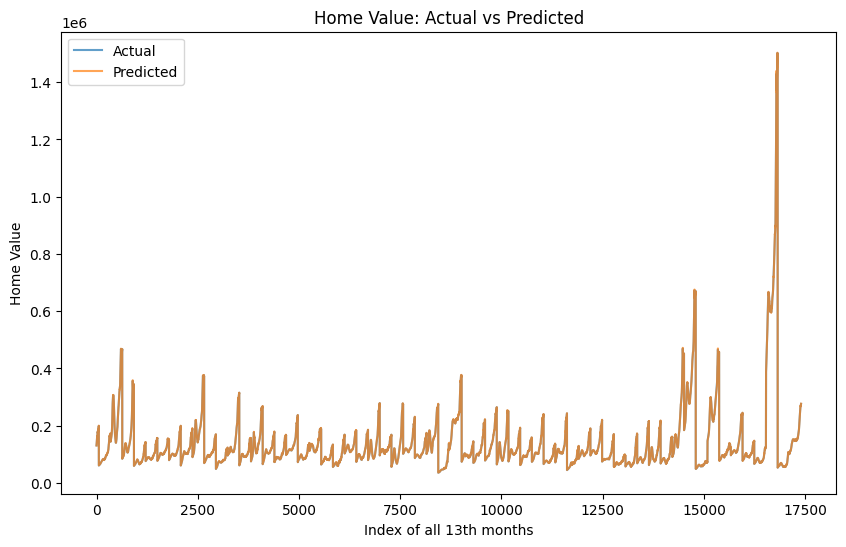

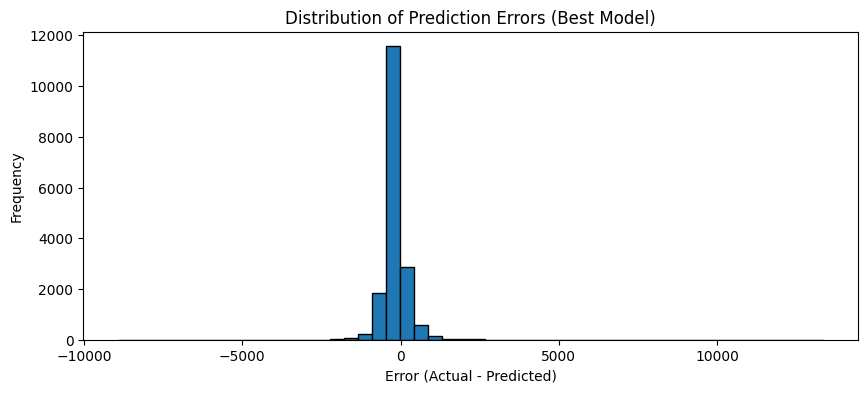

In [17]:
#  Train the final model 

best_units = int(best_combo['units'])
best_dropout = float(best_combo['dropout'])
best_lr = float(best_combo['learning_rate'])

best_model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_units=best_units,
    dropout_rate=best_dropout,
    learning_rate=best_lr
)


history = best_model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


y_pred = best_model.predict(X_test)

# Invert scaling, because we scaled them previously 

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nFinal Evaluation with Best Hyperparams:")
print(f"RMSE: {rmse:0.2f}")
print(f"MAE:  {mae:0.2f}")
print(f"R^2:  {r2:0.2f}")


# Visualization for prediction and actual 

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('Home Value: Actual vs Predicted')
plt.xlabel('Index of all 13th months')
plt.ylabel('Home Value')
plt.legend()
plt.show()

# Distribution of errors
errors = y_test_inv.flatten() - y_pred_inv.flatten()
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors (Best Model)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

